## GaussianImage: 1000 FPS Image Representation  and Compression by 2D Gaussian Splatting

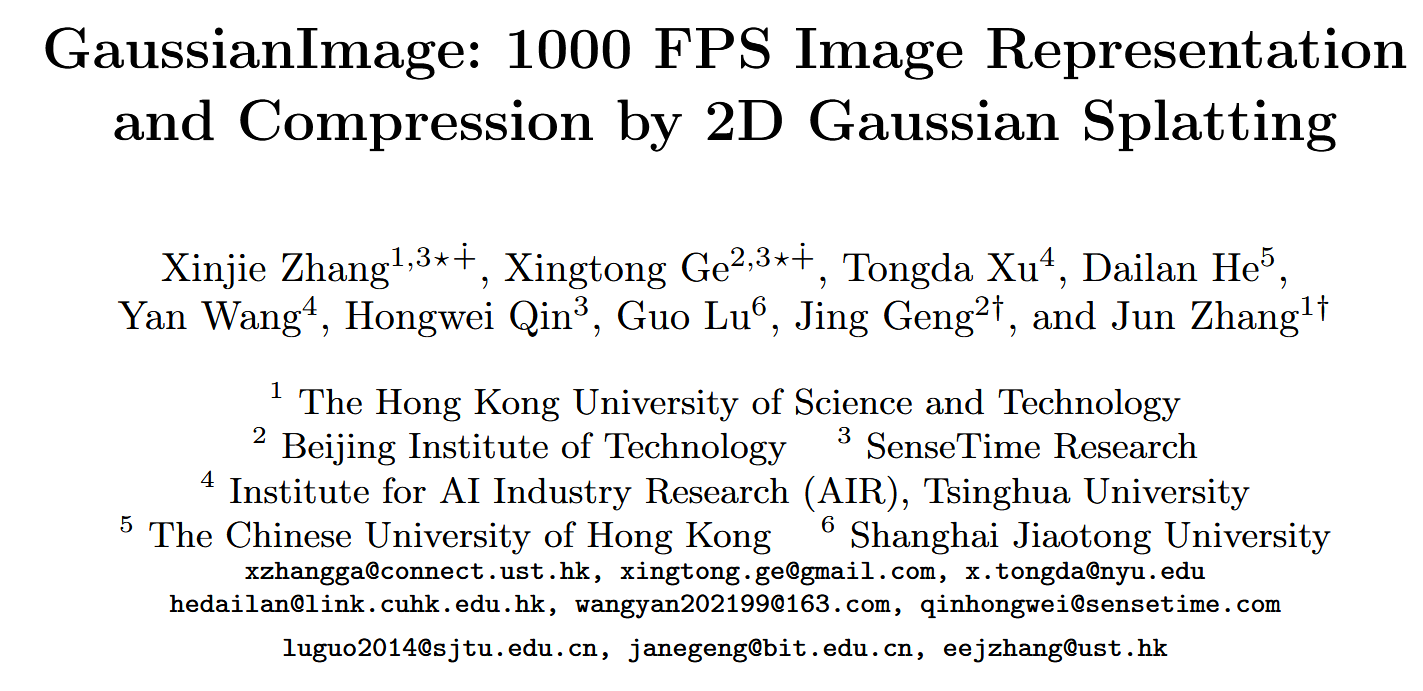

Github Repo:https://github.com/Xinjie-Q/GaussianImage, 
Corresponding code: ../../../../code/GS/GaussianImage-main/train.py
## 1. Highlights

This work transitions 3D Gaussian Splatting (3DGS) into a 2D formulation, specifically for single-image representation and compression. It inherits key advantages of 3DGS—such as high rendering quality and parallelism—while eliminating the need for camera parameters or depth sorting.
### Comparison: 3DGS vs. GaussianImage

| Feature                  | 3D Gaussian Splatting (3DGS)          | GaussianImage (2D)                   |
|--------------------------|----------------------------------------|---------------------------------------|
| Rendering Method         | Depth-sorted Alpha Blending            | Order-free Accumulated Summation     |
| Depth Required           | ✅ Yes                                 | ❌ No                                  |
| Parallelism              | ❌ Sequential (depends on order)       | ✅ Fully parallel                      |
| Use Case                 | 3D view synthesis                      | 2D image representation & compression |
| Gaussian Parameters      | 59 per Gaussian                        | 8 per Gaussian                        |

## 2. Background

Implicit neural representations (INRs) have recently gained popularity in image processing. These methods represent images as continuous functions, often modeled by MLPs, that map spatial coordinates $(x, y)$ to RGB values.  
Notable methods like SIREN [1] and WIRE [2] show impressive results in terms of image fidelity. 

Recently, 3D Gaussian Splatting [5] has been proposed in the context of 3D scene reconstruction, providing fast and visually high-quality rendering by explicitly modeling 3D Gaussians. This work inspires The Core Idea of **GaussianImage**, which brings this approach to **2D image representation and compression**.

## 2. The Core Idea
Pipeline
1. Input a high-resolution image (usually in full resolution);
2. Optimize (overfit) a set of 2D Gaussians to represent the image;
3. Store these Gaussian parameters as a compressed representation;
4. When needed for display or reconstruction, render the image from these parameters at 2000 FPS.


GaussianImage replaces MLP-based INRs with **a set of 2D Gaussians**. Each image is represented as a sum of weighted Gaussian functions in 2D space. Every Gaussian is defined by:

- Position $\mu \in \mathbb{R}^2$
- Covariance matrix $\Sigma \in \mathbb{R}^{2 \times 2}$
- Weighted color coefficient $c' \in \mathbb{R}^3$


### 2.1 Covariance matrix factorization

The covariance matrix defines the **shape**, **orientation**, and **scale** of a 2D Gaussian.  
It determines how the Gaussian spreads in space, allowing it to adapt to local image structures.  
Using a full covariance matrix enables anisotropic and rotated blobs, which are essential for accurately fitting complex image regions.

To ensure the covariance matrix $\Sigma$ is always positive semi-definite, GaussianImage uses **Cholesky decomposition**:

$$
\Sigma = LL^\top,\quad L = \begin{bmatrix} l_1 & 0 \\\\ l_2 & l_3 \end{bmatrix}
$$

This makes optimization stable and avoids invalid $\Sigma$ values during training.

➡️ *Compared to 3DGS's rotation-scaling factorization, Cholesky is simpler and compression-friendly.*

---

### 2.2 Accumulated Blending

3D Gaussian Splatting (3DGS) uses **alpha blending**:
- Needs depth sorting
- Requires camera parameters
- Sequential, not parallel

But 2D images have **no depth**. GaussianImage instead uses **accumulated summation**:

$$
C_i = \sum_{n \in N} c'_n \cdot \exp(-\sigma_n),\quad \sigma_n = \frac{1}{2} d_n^\top \Sigma^{-1} d_n
$$

No need to sort. Fully parallel. Order-invariant. Faster and more stable.

➡️ *This change enables 2000+ FPS rendering and simplifies compression.*


## References

[1] Sitzmann et al., "Implicit Neural Representations with Periodic Activation Functions", NeurIPS 2020  
[2] Saragadam et al., "WIRE: Wavelet Implicit Neural Representations", CVPR 2023  
[3] Müller et al., "Instant Neural Graphics Primitives", SIGGRAPH 2022  
[4] Chen et al., "NeuRBF: Neural Fields with Radial Basis Functions", ICCV 2023  
[5] Kerbl et al., "3D Gaussian Splatting for Real-Time Radiance Field Rendering", SIGGRAPH 2023  
[6] Townsend et al., "Practical Lossless Compression with Latent Variables using Bits-Back Coding", arXiv 2019  



In [ ]:
import os
import sys
print("Current working directory:", os.getcwd())
target_path = os.path.abspath(os.path.join(os.getcwd(), "../../../code/GS/GaussianImage-main"))
print("Appending path:", target_path)
sys.path.insert(0, target_path)

import math
import time
from pathlib import Path
import argparse
import yaml
import numpy as np
import torch
import sys
from PIL import Image
import torch.nn.functional as F
from pytorch_msssim import ms_ssim as ms_ssim_func
from utils import *
from tqdm import tqdm
import random
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Current working directory: ../../../../Awesome-Computational-Imaging/chapters/Chapter05_Gaussian_Image
Appending path: ../../../../code/GS/GaussianImage-main


`SimpleTrainer2d` is designed to train a set of learnable 2D Gaussians to approximate a given image. It supports different Gaussian formulations such as Cholesky, Rotation-Scaling, and 3DGS, and takes care of everything from loading the image and initializing the model, to training over a specified number of iterations and evaluating performance using PSNR and MS-SSIM. The final goal is to represent the image efficiently using a compact set of parameterized Gaussians, while optionally saving the output and logging the process.

In [ ]:
class SimpleTrainer2d:
    """Trains random 2d gaussians to fit an image."""
    def __init__(
        self,
        image_path: Path,
        num_points: int = 2000,
        model_name:str = "GaussianImage_Cholesky",
        iterations:int = 30000,
        model_path = None,
        args = None,
    ):
        self.device = torch.device("cuda:0")
        self.gt_image = image_path_to_tensor(image_path).to(self.device)

        self.num_points = num_points
        image_path = Path(image_path)
        self.image_name = image_path.stem
        BLOCK_H, BLOCK_W = 16, 16
        self.H, self.W = self.gt_image.shape[2], self.gt_image.shape[3]
        self.iterations = iterations
        self.save_imgs = args.save_imgs
        self.log_dir = Path(f"../../../../code/GS/GaussianImage-main/checkpoints/{args.data_name}/{model_name}_{args.iterations}_{num_points}/{self.image_name}")
        
        if model_name == "GaussianImage_Cholesky":
            from gaussianimage_cholesky import GaussianImage_Cholesky
            self.gaussian_model = GaussianImage_Cholesky(loss_type="L2", opt_type="adan", num_points=self.num_points, H=self.H, W=self.W, BLOCK_H=BLOCK_H, BLOCK_W=BLOCK_W, 
                device=self.device, lr=args.lr, quantize=False).to(self.device)

        elif model_name == "GaussianImage_RS":
            from gaussianimage_rs import GaussianImage_RS
            self.gaussian_model = GaussianImage_RS(loss_type="L2", opt_type="adan", num_points=self.num_points, H=self.H, W=self.W, BLOCK_H=BLOCK_H, BLOCK_W=BLOCK_W, 
                device=self.device, lr=args.lr, quantize=False).to(self.device) 

        elif model_name == "3DGS":
            from gaussiansplatting_3d import Gaussian3D
            self.gaussian_model = Gaussian3D(loss_type="Fusion2", opt_type="adan", num_points=self.num_points, H=self.H, W=self.W, BLOCK_H=BLOCK_H, BLOCK_W=BLOCK_W, 
                device=self.device, sh_degree=args.sh_degree, lr=args.lr).to(self.device)

        self.logwriter = LogWriter(self.log_dir)

        if model_path is not None:
            print(f"loading model path:{model_path}")
            checkpoint = torch.load(model_path, map_location=self.device)
            model_dict = self.gaussian_model.state_dict()
            pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict}
            model_dict.update(pretrained_dict)
            self.gaussian_model.load_state_dict(model_dict)

    def train(self):     
        psnr_list, iter_list = [], []
        progress_bar = tqdm(range(1, self.iterations+1), desc="Training progress")
        best_psnr = 0
        self.gaussian_model.train()
        start_time = time.time()
        for iter in range(1, self.iterations+1):
            loss, psnr = self.gaussian_model.train_iter(self.gt_image)
            psnr_list.append(psnr)
            iter_list.append(iter)
            
            if iter % 100 == 0:
                with torch.no_grad():
                    progress_bar.set_postfix({f"Loss":f"{loss.item():.{7}f}", "PSNR":f"{psnr:.{4}f},"})
                    progress_bar.update(10)
                    self.gaussian_model.eval()
                    out = self.gaussian_model()
                    img_tensor = out["render"].float().squeeze(0).cpu()
                    img = transforms.ToPILImage()(img_tensor)
                    plt.imshow(img)
                    plt.title(f"Iteration {iter}")
                    plt.axis("off")
                    plt.show()
                    self.gaussian_model.train()

                
        end_time = time.time() - start_time
        progress_bar.close()
        psnr_value, ms_ssim_value = self.test()
        with torch.no_grad():
            self.gaussian_model.eval()
            test_start_time = time.time()
            for i in range(100):
                _ = self.gaussian_model()
            test_end_time = (time.time() - test_start_time)/100

        self.logwriter.write("Training Complete in {:.4f}s, Eval time:{:.8f}s, FPS:{:.4f}".format(end_time, test_end_time, 1/test_end_time))
        torch.save(self.gaussian_model.state_dict(), self.log_dir / "gaussian_model.pth.tar")
        np.save(self.log_dir / "training.npy", {"iterations": iter_list, "training_psnr": psnr_list, "training_time": end_time, 
        "psnr": psnr_value, "ms-ssim": ms_ssim_value, "rendering_time": test_end_time, "rendering_fps": 1/test_end_time})
        return psnr_value, ms_ssim_value, end_time, test_end_time, 1/test_end_time


    def test(self):
        self.gaussian_model.eval()
        with torch.no_grad():
            out = self.gaussian_model()

        mse_loss = F.mse_loss(out["render"].float(), self.gt_image.float())
        psnr = 10 * math.log10(1.0 / mse_loss.item())
        ms_ssim_value = ms_ssim_func(out["render"].float(), self.gt_image.float(), data_range=1, size_average=True).item()

        self.logwriter.write("Test PSNR:{:.4f}, MS_SSIM:{:.6f}".format(psnr, ms_ssim_value))

        if self.save_imgs:
            transform = transforms.ToPILImage()
            img = transform(out["render"].float().squeeze(0))

            # Save image
            name = self.image_name + "_fitting.png"
            img.save(str(self.log_dir / name))

            # Show image with matplotlib
            plt.imshow(img)
            plt.title(f"Prediction: {self.image_name}")
            plt.axis("off")
            plt.show()

        return psnr, ms_ssim_value


In [ ]:
def image_path_to_tensor(image_path: Path):
    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).unsqueeze(0) #[1, C, H, W]
    return img_tensor

def parse_args(argv):
    parser = argparse.ArgumentParser(description="Example training script.")
    parser.add_argument(
        "-d", "--dataset", type=str, default='../../../../Datasets/Kodak', help="Training dataset"
    )
    parser.add_argument(
        "--data_name", type=str, default='kodak', help="Training dataset"
    )
    parser.add_argument(
        "--iterations", type=int, default=50000, help="number of training epochs (default: %(default)s)"
    )
    parser.add_argument(
        "--model_name", type=str, default="GaussianImage_Cholesky", help="model selection: GaussianImage_Cholesky, GaussianImage_RS, 3DGS"
    )
    parser.add_argument(
        "--sh_degree", type=int, default=3, help="SH degree (default: %(default)s)"
    )
    parser.add_argument(
        "--num_points",
        type=int,
        default=50000,
        help="2D GS points (default: %(default)s)",
    )
    parser.add_argument("--model_path", type=str, default=None, help="Path to a checkpoint")
    parser.add_argument("--seed", type=float, default=1, help="Set random seed for reproducibility")
    parser.add_argument("--save_imgs", action="store_true", help="Save image")
    parser.add_argument(
        "--lr",
        type=float,
        default=1e-3,
        help="Learning rate (default: %(default)s)",
    )
    args = parser.parse_args(argv)
    return args


`main(argv)`: Batch Image Training and Evaluation

This function runs `SimpleTrainer2d` on an entire dataset (e.g., Kodak or DIV2K). For each image, it trains a set of 2D Gaussians to minimize L2 loss and logs metrics such as PSNR, MS-SSIM, training time, and FPS. All results are saved using `LogWriter`, and the script computes the average performance across all images to evaluate model quality and speed.

In [ ]:
argv=sys.argv[1:]
args = parse_args([])  
# Cache the args as a text string to save them in the output dir later
args_text = yaml.safe_dump(args.__dict__, default_flow_style=False)

if args.seed is not None:
    torch.manual_seed(args.seed)
    random.seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(args.seed)

logwriter = LogWriter(Path(f"./checkpoints/{args.data_name}/{args.model_name}_{args.iterations}_{args.num_points}"))
psnrs, ms_ssims, training_times, eval_times, eval_fpses = [], [], [], [], []
image_h, image_w = 0, 0
if args.data_name == "kodak":
    image_length, start = 24, 0
elif args.data_name == "DIV2K_valid_LRX2":
    image_length, start = 100, 800
for i in range(start, start+image_length):
    if args.data_name == "kodak":
        image_path = Path(args.dataset) / f'{i+1}.png'
    elif args.data_name == "DIV2K_valid_LRX2":
        image_path = Path(args.dataset) /  f'{i+1:04}x2.png'

    trainer = SimpleTrainer2d(image_path=image_path, num_points=args.num_points, 
        iterations=args.iterations, model_name=args.model_name, args=args, model_path=args.model_path)
    psnr, ms_ssim, training_time, eval_time, eval_fps = trainer.train()
    psnrs.append(psnr)
    ms_ssims.append(ms_ssim)
    training_times.append(training_time) 
    eval_times.append(eval_time)
    eval_fpses.append(eval_fps)
    image_h += trainer.H
    image_w += trainer.W
    image_name = image_path.stem
    logwriter.write("{}: {}x{}, PSNR:{:.4f}, MS-SSIM:{:.4f}, Training:{:.4f}s, Eval:{:.8f}s, FPS:{:.4f}".format(
        image_name, trainer.H, trainer.W, psnr, ms_ssim, training_time, eval_time, eval_fps))

avg_psnr = torch.tensor(psnrs).mean().item()
avg_ms_ssim = torch.tensor(ms_ssims).mean().item()
avg_training_time = torch.tensor(training_times).mean().item()
avg_eval_time = torch.tensor(eval_times).mean().item()
avg_eval_fps = torch.tensor(eval_fpses).mean().item()
avg_h = image_h//image_length
avg_w = image_w//image_length

logwriter.write("Average: {}x{}, PSNR:{:.4f}, MS-SSIM:{:.4f}, Training:{:.4f}s, Eval:{:.8f}s, FPS:{:.4f}".format(
    avg_h, avg_w, avg_psnr, avg_ms_ssim, avg_training_time, avg_eval_time, avg_eval_fps))    

/home/xqgao/anaconda3/envs/inr/lib/python3.12/site-packages/jaxtyping/__init__.py:231: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(
Training progress:  16%|█▋        | 8170/50000 [00:13<01:06, 630.57it/s, Loss=0.0001703, PSNR=37.6876,]

KeyboardInterrupt: 

Training progress:  16%|█▋        | 8180/50000 [00:29<01:06, 630.57it/s, Loss=0.0001703, PSNR=37.6876,]